In [291]:
from pykat import finesse 
       
from pykat.commands import *     
import numpy as np   
import pandas as pd            
import matplotlib.pyplot as plt  
import scipy.signal                
from IPython import display
              
%matplotlib inline
pykat.init_pykat_plotting(dpi=200)

In [292]:
kat1 = finesse.kat()
kat1.verbose=True
kat1.parse("""

l laser 30 0 n1                          #laser 30W
maxtem 3
s gap01 1 n1 n2                         #space b/w mod and laser  
mod eom1 $sb1 0.18 3 pm n2 n3         #modulator PM $sb1 3f
s gap02 0.5 n3 n31a                     #space b/w mod and PRM      


##### FOR ANGULAR SENSING PRM #####
bs pickoff 0.0001 0.9999 0 45 n31a dump n32 refl_a
s s2 0.1 refl_a a8                       
bs bsQPD 0.5 0.5 0 45 a8 a9 a10 dump            #bs to split power between two detectors 

s sQPD1 0.1 a9 a11                   
s sQPD2 0.1 a10 a12
#########################


####### 3 m setup ###########

s gap03 0.5 n32 refl

m PRM 0.899 0.1 0 refl pop               #PRM                ---> POP <---

#m PRM 0 1 90 refl pop

##### folding mirrors #####
s prc 0.5 pop bs1a
bs bs1 0.999 0.001 0 0 bs1a bs12 bs12tr dump
s b1 0.350 bs12 bs21
bs bs2 0.999 0.001 0 0 bs21 bs21a bs21tr dump
s b2 0.5 bs21a b3    
###########################

#m PRM 0 1 90 refl pop               #PRM
#s PRC 1.33 pop b3                        #PRC 
m ITM 0.98997 0.01 0 b3 n12              #ITM
s ARM 3.3 n12 b5                        #ARM length 3.3 (0.01 from sr length) 
m ETM 0.99996 0.00001 0 b5 b6           #ETM
#m ETM 0 1 0 b5 b6 

################################


cav ARML ITM n12 ETM b5 
cav PRCL PRM pop ITM b3



##### attr for TM ######
attr ETM Rc 11.3            # RoC of ETM
attr PRM Rc -23.6           # RoC of PRM
attr PRM xbeta 0            # misalgnment PRM
attr ETM xbeta 0            # misalgnment ETM
attr ITM xbeta 0            # misalgnment ITM
######################


#trace 2 
#phase 2

const sb1 55.556M
const sb2 111.112M
const sb3 166.668M



""")

--------------------------------------------------------------
Running kat - Started at 2022-11-29 19:13:53.465904


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 15.0827 seconds

--- Output info ---

Run date and time: 2022-11-29 19:13:53.466979
Detectors used: circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis PRM phi lin 30 110 8000']
circ_arm : min = 4.042192495003850e+02 max = 2.583400048360900e+05
circ_prc : min = 1.241353609231100e+00 max = 6.763212546084810e+02
refl     : min = 8.539151719068260e+00 max = 2.993149049418970e+01
trans    : min = 4.042354189171410e-03 max = 2.583503388496440e+00


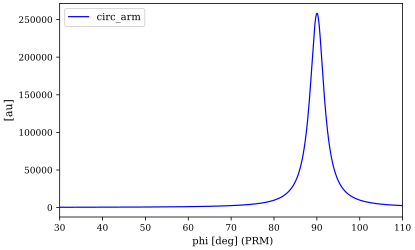

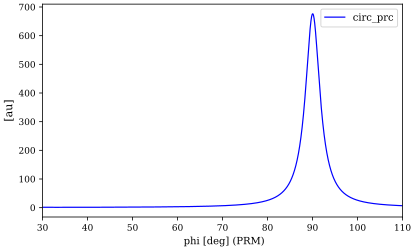

max power arm 258340.00483609
max power prc 676.321254608481
array number [[6003]]
PRM tuning for max power in arm and prc [[90.03]]


In [293]:
#### DC PDs ##########

kat_dc = kat1.deepcopy()
kat_dc.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis PRM phi lin 30 110 8000


""")

out_dc = kat_dc.run()
out_dc.info()
out_dc.plot(['circ_arm'])
out_dc.plot(['circ_prc'])
print("max power arm",max(out_dc['circ_arm']))
print("max power prc",max(out_dc['circ_prc']))
print("array number",np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm'])))
print("PRM tuning for max power in arm and prc",out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))])


### SET PRM phi ###
kat1.PRM.phi = out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))]

--------------------------------------------------------------
Running kat - Started at 2022-11-29 19:14:09.915731


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 12.4715 seconds

--- Output info ---

Run date and time: 2022-11-29 19:14:09.915731
Detectors used: circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis ETM phi lin -0.05 0.05 8000']
circ_arm : min = 2.537537122842160e+03 max = 2.583400048360900e+05
circ_prc : min = 2.385076569155780e+01 max = 6.763212546084810e+02
refl     : min = 8.539151719068260e+00 max = 2.967013182224410e+01
trans    : min = 2.537638628387300e-02 max = 2.583503388496440e+00


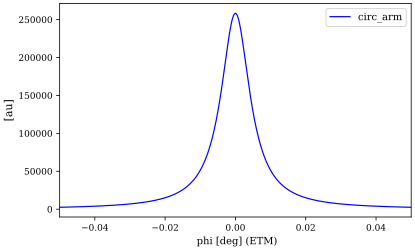

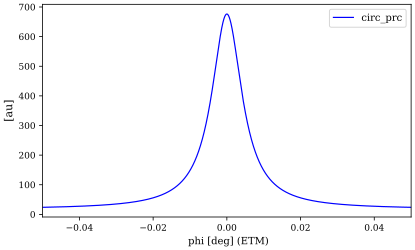

max power arm 258340.00483609
half max power arm 129170.002418045
array number max [[4000]]
Nearest element to the given values is : array number half 129224.871203197
array number max [[4398]]
detuning left [[0.004975]]


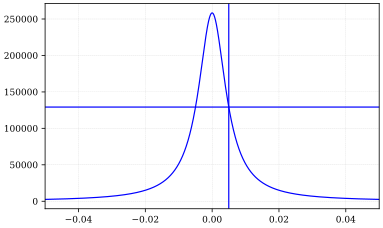

In [294]:
kat_dt = kat1.deepcopy()
kat_dt.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis ETM phi lin -0.05 0.05 8000


""")
out_dt = kat_dt.run()
out_dt.info()
out_dt.plot(['circ_arm'])
out_dt.plot(['circ_prc'])

print("max power arm",max(out_dt['circ_arm']))
print("half max power arm",max(out_dt['circ_arm'])/2)

difference_array = np.absolute(out_dt['circ_arm']-max(out_dt['circ_arm'])/2)
index = difference_array.argmin()
detuning  = np.argwhere(out_dt['circ_arm'] == out_dt['circ_arm'][index])

print("array number max",np.argwhere(out_dt['circ_arm'] == max(out_dt['circ_arm'])))
print("Nearest element to the given values is : array number half", out_dt['circ_arm'][index])
print("array number max",np.argwhere(out_dt['circ_arm'] == out_dt['circ_arm'][index]))
print("detuning left",out_dt.x[detuning])
kat1.ETM.phi = -out_dt.x[detuning]
plt.plot(out_dt.x,out_dt['circ_arm'],label="circ power arm")
plt.axhline(y=max(out_dt['circ_arm'])/2)
plt.axvline(x=out_dt.x[detuning])

--------------------------------------------------------------
Running kat - Started at 2022-11-29 19:14:23.565895


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 6.10965 seconds

--- Output info ---

Run date and time: 2022-11-29 19:14:23.565895
Detectors used: ETM_z, ITM_z, PRM_z, circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis aforce f log 0.01 10000 1000']
PRM_z Abs            : min = 3.369527936568920e-13 max = 1.144245814641830e+02
PRM_z Phase [Deg]    : min = -1.799983547446690e+02 max = 1.799990817954670e+02
ITM_z Abs            : min = 1.273371273852150e-10 max = 5.746526247276430e+01
ITM_z Phase [Deg]    : min = -1.799995832324100e+02 max = -1.732761537236830e-04
ETM_z Abs            : min = 8.319679304916779e-09 max = 5.703359224892650e+01
ETM_z Phase [Deg]    : min = -1.799999965706900e+02 max = 1.799999900335080e+02
circ_arm Abs         : min = 1.293820750291960e+05 max = 1.293820750291960e+05
circ_arm Phase [Deg] : min = 0.000000000000000e+00 max = 0.000000000000000e+00
circ_prc Abs         : min = 3.473793792837710e+02 max = 3.47379379283771

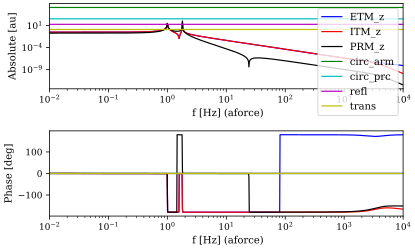

In [295]:
kat_tf = kat1.deepcopy()
kat_tf.parse("""

tf sus1 1 0 p 1 3000
attr PRM mass 0.03 zmech sus1
attr ITM mass 0.03 zmech sus1
attr ETM mass 0.03 zmech sus1


fsig aforce ETM Fz 1 0 1
xd PRM_z PRM z
xd ITM_z ITM z
xd ETM_z ETM z




pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6

xaxis aforce f log 0.01 10k 1000
yaxis log abs:deg


""")


out_df = kat_tf.run()
out_df.info()
out_df.plot()


In [296]:

print(abs(out_df['PRM_z']))

[1.95334714e-01 1.95335431e-01 1.95336168e-01 ... 3.95660994e-13
 3.65140984e-13 3.36952794e-13]


In [297]:
print(np.angle(out_df['PRM_z']))

[-4.35520128e-06 -4.41818462e-06 -4.48029625e-06 ... -2.63764833e+00
 -2.63738574e+00 -2.63706545e+00]


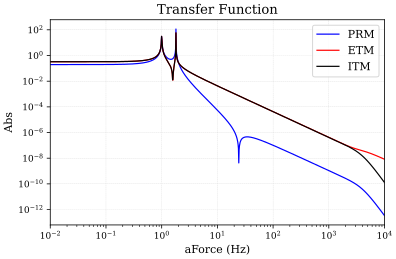

In [298]:
plt.plot(out_df.x, abs(out_df['PRM_z']),label='PRM')
plt.plot(out_df.x, abs(out_df['ETM_z']),label='ETM')
plt.plot(out_df.x, abs(out_df['ITM_z']),label='ITM')
plt.xscale("log")
plt.yscale("log")
plt.title("Transfer Function")
plt.xlabel("aForce (Hz)")
plt.ylabel("Abs")
plt.legend()

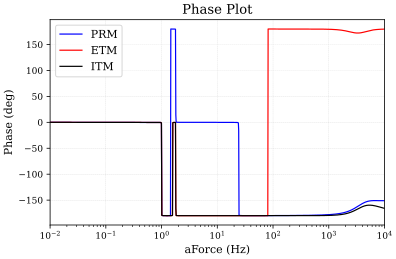

In [299]:
plt.plot(out_df.x, np.angle(out_df['PRM_z'],deg=True),label='PRM')
plt.plot(out_df.x, np.angle(out_df['ETM_z'],deg=True),label='ETM')
plt.plot(out_df.x, np.angle(out_df['ITM_z'],deg=True),label='ITM')
plt.xscale("log")
plt.title("Phase Plot")
plt.xlabel("aForce (Hz)")
plt.ylabel("Phase (deg)")
plt.legend()

c:\Users\Parivesh\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


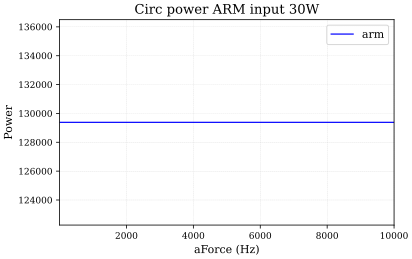

In [300]:
plt.plot(out_df.x, (out_df['circ_arm']),label='arm')
#plt.xscale("log")
plt.title("Circ power ARM input 30W")
plt.xlabel("aForce (Hz)")
plt.ylabel("Power")
plt.legend()

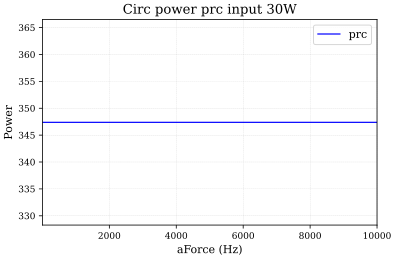

In [301]:
plt.plot(out_df.x, (out_df['circ_prc']),label='prc')
#plt.xscale("log")
plt.title("Circ power prc input 30W")
plt.xlabel("aForce (Hz)")
plt.ylabel("Power")
plt.legend()

--------------------------------------------------------------
Running kat - Started at 2022-11-29 19:14:33.294431


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 5.21357 seconds

--- Output info ---

Run date and time: 2022-11-29 19:14:33.295452
Detectors used: ETM_z, ITM_z, PRM_z, circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis aforce f log 0.1 4 800']
PRM_z Abs            : min = 0.000000000000000e+00 max = 0.000000000000000e+00
PRM_z Phase [Deg]    : min = 0.000000000000000e+00 max = 0.000000000000000e+00
ITM_z Abs            : min = 5.504086592661250e-04 max = 1.464496843616410e+03
ITM_z Phase [Deg]    : min = -1.799898424790460e+02 max = 1.799959592393300e+02
ETM_z Abs            : min = 1.683175848928070e-01 max = 1.673892980598370e+03
ETM_z Phase [Deg]    : min = -1.799949236066410e+02 max = -2.041114046533170e-03
circ_arm Abs         : min = 2.583400048360900e+05 max = 2.583400048360900e+05
circ_arm Phase [Deg] : min = 0.000000000000000e+00 max = 0.000000000000000e+00
circ_prc Abs         : min = 6.763212546084810e+02 max = 6.763212546084810e+02
c

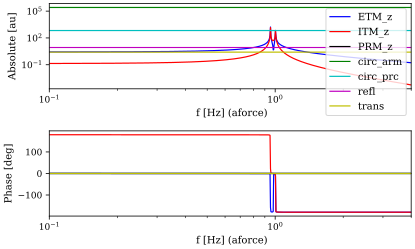

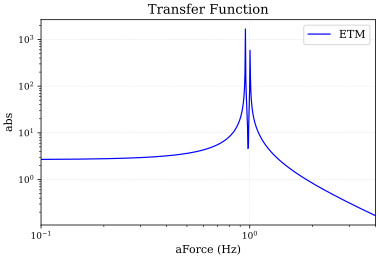

In [302]:
kat1.ETM.phi = 0
kat1.laser.P = 30
kat_tf1 = kat1.deepcopy()
kat_tf1.parse("""
tf sus1 1 0 p 1 3000

#attr PRM Ix 0.01 rxmech sus1
attr ITM Ix 0.01 rxmech sus1
attr ETM Ix 0.01 rxmech sus1

fsig aforce ETM Frx 1 0 1

xd PRM_z PRM rx
xd ITM_z ITM rx
xd ETM_z ETM rx

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6

xaxis aforce f log 0.1 0.004k 800
yaxis log abs:deg
""")

out_df1 = kat_tf1.run()
out_df1.info()
out_df1.plot()
#plt.plot(out_df1.x, abs(out_df1['PRM_z']),label='PRM')
plt.plot(out_df1.x,abs(out_df1['ETM_z']),label='ETM')
#plt.plot(out_df1.x, abs(out_df1['ITM_z']),label='ITM')
plt.xscale("log")
plt.yscale("log")
plt.title("Transfer Function")
plt.xlabel("aForce (Hz)")
plt.ylabel("abs")
plt.legend()
#print(abs(out_df1['ETM_z']))



[0.95336492 0.98010955 1.00296896]
[0.98010955]
[0.95336492 1.00296896]


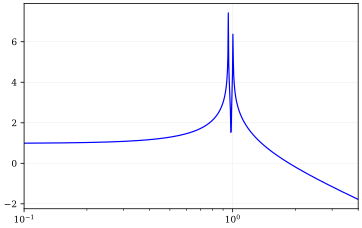

In [303]:
a = np.diff(np.sign(np.diff( np.log(out_df1['ETM_z'])))).nonzero()[0] + 1               # local min & max
b = (np.diff(np.sign(np.diff(np.log(out_df1['ETM_z'])))) > 0).nonzero()[0] + 1         # local min
c = (np.diff(np.sign(np.diff(np.log(out_df1['ETM_z'])))) < 0).nonzero()[0] + 1

print(np.real(out_df1.x[a]))
print(np.real(out_df1.x[b]))
print(np.real(out_df1.x[c]))

plt.plot(out_df1.x, np.log(out_df1['ETM_z']),label='ETM')
plt.xscale("log")
#plt.yscale("log")
#plt.axvloge(x=out_df1.x[c][0])
#plt.axvloge(x=out_df1.x[c][1])
#
#plt.axvloge(x=out_df1.x[b][0])
#plt.axvloge(x=out_df1.x[b][1])



In [304]:
w0 = 10*np.pi
L = 3.3
#I = 0.000047
I = 2.3437500000000002e-06
c = 3*1e8
g1 = 0.708
g2 = 1

x = np.linspace(0, 0.005*1e7, 100000)

y_1 = ((w0**2) + ((x*L)/(I*c))*(-(g1+g2)+(4+(g1-g2)**2)**0.5)/(1-g1*g2))**0.5

y_2 = np.real(np.emath.sqrt((((w0**2) + ((x*L)/(I*c))*(-(g1+g2)-(4+(g1-g2)**2)**0.5)/(1-g1*g2)))))
y_21 = -1*np.imag(np.emath.sqrt((((w0**2) + ((x*L)/(I*c))*(-(g1+g2)-(4+(g1-g2)**2)**0.5)/(1-g1*g2)))))

y_3 = np.real(np.emath.sqrt((((w0**2)-(2*x*L/(c*I))*(g2/(1-g2*g1))))))
y_31 = -1*np.imag(np.emath.sqrt((((w0**2)-(2*x*L/(c*I))*(g2/(1-g2*g1))))))


y_2zero = x[np.argwhere(y_2 == 0)[0]]
y_3zero = x[np.argwhere(y_3 == 0)[0]]

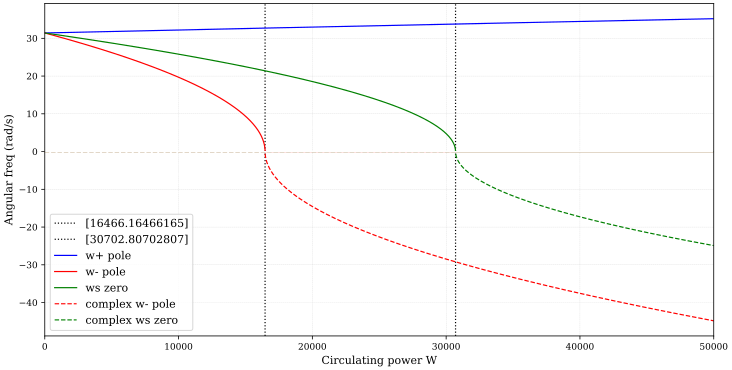

In [305]:
plt.figure(figsize=(12, 6))

plt.axvline(x=y_2zero,label = str(y_2zero),linestyle = "dotted",color = "black")
plt.axvline(x=y_3zero,label = str(y_3zero),linestyle = "dotted",color = "black") 


plt.plot(x, y_1,label="w+ pole")
plt.plot(x, y_2,color = 'red',label="w- pole")
plt.plot(x, y_3,color = 'green',label="ws zero")
plt.plot(x, y_21,color = 'red',linestyle = '--',label="complex w- pole")
plt.plot(x, y_31,color = 'green',linestyle = '--',label="complex ws zero")

plt.axhline(y=0,color="white")
plt.xlabel("Circulating power W")
plt.ylabel("Angular freq (rad/s)")
plt.legend()

--------------------------------------------------------------
Running kat - Started at 2022-11-29 19:14:41.405639
Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 0.199774 seconds


100% | ETA:  0:00:00 | Saving data                                             

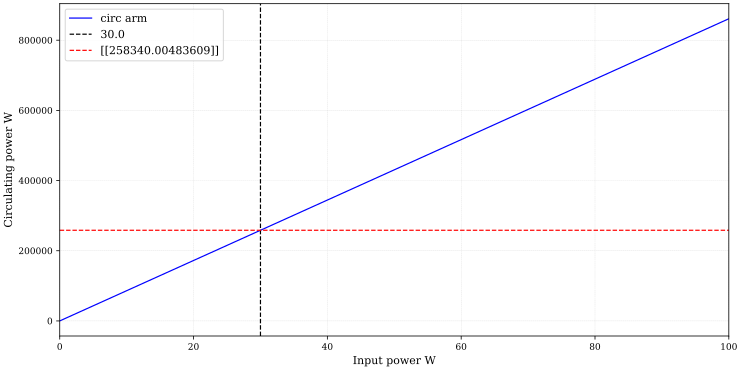

In [306]:
ip = kat1.laser.P
kat1.ETM.phi = 0
kat_tf2 = kat1.deepcopy()
kat_tf2.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis laser P lin 0 100 100

""")
plt.figure(figsize=(12, 6))
out_df2 = kat_tf2.run()
plt.plot(out_df2.x,out_df2['circ_arm'],label = "circ arm")
#plt.plot(out_df2.x,out_df2['circ_prc'],label = "circ prc")
#plt.yscale("log")
#plt.xscale("log")
plt.axvline(x=ip,label = ip,linestyle = "--",color = "black")
plt.axhline(y = out_df2['circ_arm'][np.argwhere(out_df2.x == ip)],label = out_df2['circ_arm'][np.argwhere(out_df2.x == ip)],linestyle = "--",color = "red")
plt.xlabel("Input power W")
plt.ylabel("Circulating power W")
plt.legend()

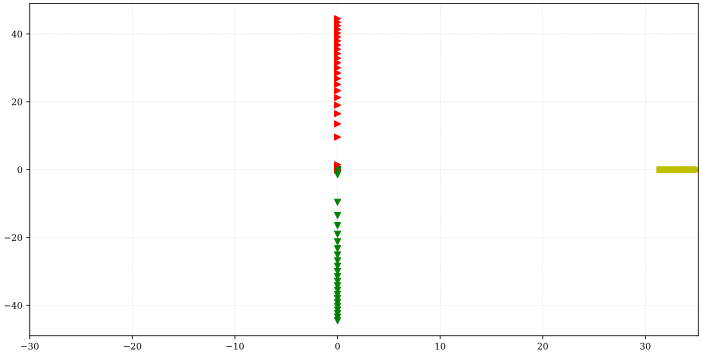

In [307]:
plt.figure(figsize=(12, 6))
i = 1
j= 1
while i in range(len(y_2)):
    plt.plot(y_1[i],0,marker=">", color='y')
    plt.plot(0,-y_21[i],marker=">", color='r')
    plt.plot(0,y_21[i],marker="v",color='g')
    #print(y_2[i])
    i = i+3000
    j = j+3000

plt.plot(-30,-30,color='white')
plt.plot(-30,30,color='white')

max constant -1564988.406345279
detuning [-0.00150371]


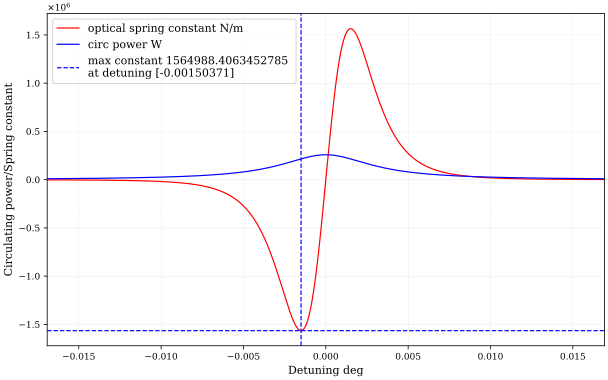

In [308]:
plt.figure(figsize=(10,6))

lamb = 1064*1e-9
xi = ((np.linspace(-0.005e-8,0.005e-8,8000))*360)/lamb

c = 299792458
ga = 258169.41/666
gb = 666/30
#F = 620
F = (2.28e8)/2580
Pin = 30
P0 = (ga)*(gb)*Pin*(1/(1+F*(np.sin(xi)**2)))
K = (8*np.pi*P0*F*xi)/(c*lamb*(1+F*xi**2)**2)


plt.plot(xi,K,label="optical spring constant N/m",color = "red")
plt.plot(xi,P0,label="circ power W")


print("max constant",min(K))
plt.axvline(x= xi[np.where(K == min(K))],linestyle = "--")
plt.axhline(y=min(K),label = "max constant " +str(max(K)) +" \nat detuning " + str(xi[np.where(K == min(K))]),linestyle = "--")
print("detuning",xi[np.where(K == min(K))])
plt.xlabel("Detuning deg")
plt.ylabel("Circulating power/Spring constant")
plt.legend()

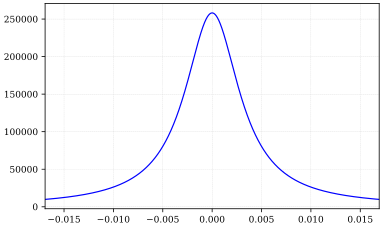

In [309]:
plt.plot(xi,P0)

In [310]:
r = 0.001568
E = min(K)*3.3/(np.pi*r*r)
print("Young's modulus",E)
print("Young's modulus wrt diamond",E/(1.05*1e12))

Young's modulus -668625714610.68
Young's modulus wrt diamond -0.6367863948673144
